In [1]:
#pip install -r requirements.txt

# create dataloaders for the model

In [2]:
# creating sample input to the model
import torch
import sys
sys.path.append("C:\\Users\\PC\\Desktop\\lisnen_segmented_working_data\\CNN_files\\audioset_tagging_cnn\\pytorch")
from models import Cnn14
sample_rate = 32000
window_size=1024
hop_size=320
mel_bins=64
fmin=50
fmax=14000
class_num=4
model = Cnn14(sample_rate,window_size,hop_size,mel_bins,fmin,fmax,class_num)
random_input = torch.randn(32,32000)  #torch.randn(batch_size,data_length)
with torch.no_grad():
    spec_output=model.spectrogram_extractor(random_input)
    print('output of spectrogram:',spec_output.shape)
    log_mel_output = model.logmel_extractor(spec_output)
    print('output of log mel:',log_mel_output.shape)

    

output of spectrogram: torch.Size([32, 1, 101, 513])
output of log mel: torch.Size([32, 1, 101, 64])


# loading the data and creating log mel spectrograms

In [3]:
import os
import random
import librosa
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

class AudioDataset(Dataset):
    def __init__(self, audio_files, labels, transform=None, max_length=512):
        self.audio_files = audio_files
        self.labels = labels
        self.transform = transform
        self.max_length = max_length

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        audio_path = self.audio_files[idx]
        label = self.labels[idx]

        # Load audio file
        y, sr = librosa.load(audio_path, sr=32000)

        # Filter out zero-length audio files
        if len(y) == 0:
            print(f"Warning: {audio_path} has zero length.")
            return self.__getitem__((idx + 1) % len(self))

        # Convert to Mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, fmin=50, fmax=14000)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # Pad or trim to max_length
        if log_mel_spectrogram.shape[1] < self.max_length:
            pad_width = self.max_length - log_mel_spectrogram.shape[1]
            log_mel_spectrogram = np.pad(log_mel_spectrogram, ((0, 0), (0, pad_width)), mode='constant')
        else:
            log_mel_spectrogram = log_mel_spectrogram[:, :self.max_length]

        if self.transform:
            log_mel_spectrogram = self.transform(log_mel_spectrogram)

        log_mel_spectrogram = torch.tensor(log_mel_spectrogram, dtype=torch.float32).unsqueeze(0)  # Shape [1, time_steps, mel_bins]

        return log_mel_spectrogram, torch.tensor(label, dtype=torch.long)  # Ensure label is a long tensor

# Define classes
classes = ['Baby_Cry', 'Door_Bell', 'Door_Knock', 'Fire_Alarm']

# Path to the audio directory
audio_dir = "C:\\Users\\PC\\Desktop\\lisnen_segmented_working_data\\audio_files"

# Collect all audio files and their labels
audio_files = []
labels = []

for label, class_name in enumerate(classes):
    class_dir = os.path.join(audio_dir, class_name)
    for file_name in os.listdir(class_dir):
        if file_name.endswith('.wav'):  # Assuming audio files are in .wav format
            audio_files.append(os.path.join(class_dir, file_name))
            labels.append(label)

# Shuffle and split the data into training, validation, and test sets (80-10-10 ratio)
audio_files_train, audio_files_temp, labels_train, labels_temp = train_test_split(audio_files, labels, test_size=0.2, stratify=labels, random_state=42)
audio_files_val, audio_files_test, labels_val, labels_test = train_test_split(audio_files_temp, labels_temp, test_size=0.5, stratify=labels_temp, random_state=42)

# Create datasets with max_length
max_length = 512  # Adjusted based on the distribution analysis
train_dataset = AudioDataset(audio_files_train, labels_train, max_length=max_length)
val_dataset = AudioDataset(audio_files_val, labels_val, max_length=max_length)
test_dataset = AudioDataset(audio_files_test, labels_test, max_length=max_length)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Data loaders created successfully!")


Data loaders created successfully!


C:\Users\PC\.conda\envs\pretrained\lib\site-packages\librosa\core\spectrum.py:267: UserWarning: n_fft=2048 is too large for input signal of length=0
  f"n_fft={n_fft} is too large for input signal of length={y.shape[-1]}"
C:\Users\PC\.conda\envs\pretrained\lib\site-packages\librosa\core\spectrum.py:267: UserWarning: n_fft=2048 is too large for input signal of length=1505
  f"n_fft={n_fft} is too large for input signal of length={y.shape[-1]}"


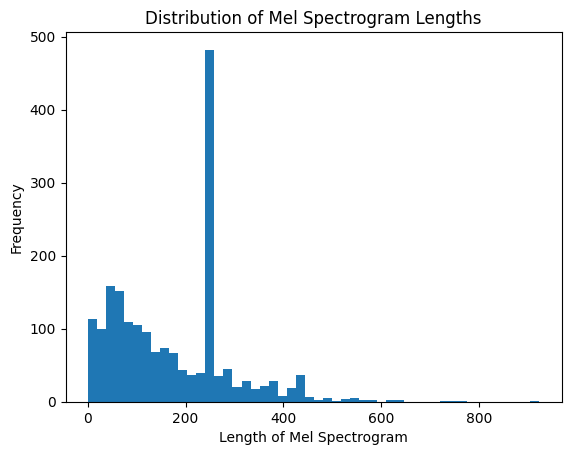

In [4]:
import librosa
import matplotlib.pyplot as plt

# Function to compute Mel spectrogram lengths
def compute_mel_spectrogram_length(audio_file):
    y, sr = librosa.load(audio_file, sr=32000)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, fmin=50, fmax=14000)
    return mel_spectrogram.shape[1]

# Calculate lengths of Mel spectrograms for all audio files
mel_lengths = [compute_mel_spectrogram_length(f) for f in audio_files]

# Plot the distribution of lengths
plt.hist(mel_lengths, bins=50)
plt.xlabel('Length of Mel Spectrogram')
plt.ylabel('Frequency')
plt.title('Distribution of Mel Spectrogram Lengths')
plt.show()


# creating dataloaders to the model

# creating a train model 

Since the pretrained model is trained on 527 classes, we have only 4 classes. so we need to modify the existing cnn last layer

In [5]:
# from models import Cnn14  # Ensure you have the correct import path

# class ModifiedCnn14(Cnn14):  #to change the model to take our input and classes
#     def __init__(self, sample_rate, window_size, hop_size, mel_bins, fmin, fmax, classes_num):
#         super(ModifiedCnn14, self).__init__(sample_rate, window_size, hop_size, mel_bins, fmin, fmax, classes_num)
#         #super(ModifiedCnn14, self).__init__()
#         # Initialize Cnn14
#         self.cnn14 = Cnn14(sample_rate, window_size, hop_size, mel_bins, fmin, fmax, classes_num)
#         # Replace the initial layers to accept Mel spectrograms directly
#         self.cnn14.spectrogram_extractor = nn.Identity()
#         self.cnn14.logmel_extractor = nn.Identity()
#         self.fc_audioset = nn.Linear(2048, classes_num)

# # Define the required parameters
# sample_rate = 32000
# window_size = 1024
# hop_size = 320
# mel_bins = 64
# fmin = 50
# fmax = 14000
# classes_num = 4  # Number of classes in your dataset

# # Initialize the modified model
# model = ModifiedCnn14(sample_rate, window_size, hop_size, mel_bins, fmin, fmax, classes_num)


In [6]:
import torch
import torch.nn as nn
from models import Cnn14

class ModifiedCnn14(nn.Module):
    def __init__(self, sample_rate, window_size, hop_size, mel_bins, fmin, fmax, classes_num):
        super(ModifiedCnn14, self).__init__()
        # Initialize Cnn14
        self.cnn14 = Cnn14(sample_rate, window_size, hop_size, mel_bins, fmin, fmax, classes_num)
        # Replace the initial layers to accept Mel spectrograms directly
        self.cnn14.spectrogram_extractor = nn.Identity()
        self.cnn14.logmel_extractor = nn.Identity()

        # Update the fc1 layer to match the output shape from the convolutional layers
        self.cnn14.fc1 = nn.Sequential(
            nn.Linear(in_features=2048, out_features=2048),  # Adjust the input features based on the output size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=2048, out_features=2048),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

    def forward(self, x):
        x = self.cnn14.spec_augmenter(x)
        
        #print(f"Shape before conv_block1: {x.shape}")
        x = self.cnn14.conv_block1(x, pool_size=(2, 2), pool_type='avg')
        #print(f"Shape after conv_block1: {x.shape}")

        x = self.cnn14.conv_block2(x, pool_size=(2, 2), pool_type='avg')
        #print(f"Shape after conv_block2: {x.shape}")

        x = self.cnn14.conv_block3(x, pool_size=(2, 2), pool_type='avg')
        #print(f"Shape after conv_block3: {x.shape}")

        x = self.cnn14.conv_block4(x, pool_size=(2, 2), pool_type='avg')
        #print(f"Shape after conv_block4: {x.shape}")

        x = torch.mean(x, dim=3)
        #print(f"Shape after mean: {x.shape}")

        x = x.view(x.size(0), -1)  # Flatten the tensor to [batch_size, 2048]
        #print(f"Shape after view: {x.shape}")

        x = self.cnn14.fc1(x)
        #print(f"Shape after fc1: {x.shape}")

        x = self.cnn14.fc_audioset(x)
        
        return x

# Define the required parameters
sample_rate = 32000
window_size = 1024
hop_size = 320
mel_bins = 64
fmin = 50
fmax = 14000
classes_num = 4  # Number of classes in your dataset

# Initialize the modified model
model = ModifiedCnn14(sample_rate, window_size, hop_size, mel_bins, fmin, fmax, classes_num)


loading the pretrained weights

In [7]:
pretrained_path = 'C:\\Users\\PC\\Desktop\\lisnen_segmented_working_data\\CNN_files\\Cnn14_mAP=0.431.pth'  # Update this path to your pretrained model file
checkpoint = torch.load(pretrained_path, map_location=torch.device('cpu'))

# Load the pretrained weights, except for the final layer
model_dict = model.state_dict()
pretrained_dict = {k: v for k, v in checkpoint['model'].items() if k in model_dict and 'fc_audioset' not in k}
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)
model.eval()


ModifiedCnn14(
  (cnn14): Cnn14(
    (spectrogram_extractor): Identity()
    (logmel_extractor): Identity()
    (spec_augmenter): SpecAugmentation(
      (time_dropper): DropStripes()
      (freq_dropper): DropStripes()
    )
    (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_block1): ConvBlock(
      (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_block2): ConvBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, af

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

print("Model, loss function, and optimizer defined successfully!")

# Define the training function with debugging
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, (inputs, labels) in enumerate(dataloader):
#                 print(f"Batch {i}:")
#                 print(f"  inputs shape: {inputs.shape}, dtype: {inputs.dtype}")
#                 print(f"  labels shape: {labels.shape}, dtype: {labels.dtype}")

                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    print(f"  outputs shape: {outputs.shape}")
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Number of epochs
num_epochs = 100

# Train and evaluate the model
model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)


Model, loss function, and optimizer defined successfully!
Epoch 0/99
----------
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32,

  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([2, 4])
val Loss: 1.1756 Acc: 0.4330

Epoch 1/99
----------
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.S

  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([2, 4])
val Loss: 1.1284 Acc: 0.5155

Epoch 2/99
----------
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.S

  outputs shape: torch.Size([16, 4])
train Loss: 1.1312 Acc: 0.5116
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([2, 4])
val Loss: 1.4410 Acc: 0.2732

Epoch 3/99
----------
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([3

  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([16, 4])
train Loss: 1.0544 Acc: 0.5464
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([2, 4])
val Loss: 0.8001 Acc: 0.6598

Epoch 4/99
----------
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([3

  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([16, 4])
train Loss: 0.9884 Acc: 0.5928
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([2, 4])
val Loss: 0.9212 Acc: 0.5979

Epoch 5/99
----------
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([3

  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([16, 4])
train Loss: 0.9400 Acc: 0.6089
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([2, 4])
val Loss: 0.7787 Acc: 0.7371

Epoch 6/99
----------
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([3

  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([16, 4])
train Loss: 0.8995 Acc: 0.6231
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([2, 4])
val Loss: 0.6167 Acc: 0.7577

Epoch 7/99
----------
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([3

  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([16, 4])
train Loss: 0.8488 Acc: 0.6553
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([2, 4])
val Loss: 1.2809 Acc: 0.5464

Epoch 8/99
----------
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([3

  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([16, 4])
train Loss: 0.8571 Acc: 0.6514
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([2, 4])
val Loss: 0.6035 Acc: 0.7423

Epoch 9/99
----------
  outputs shape: torch.Size([3

  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([16, 4])
train Loss: 0.8138 Acc: 0.6714
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outpu

  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([16, 4])
train Loss: 0.8018 Acc: 0.6527
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outpu

  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([16, 4])
train Loss: 0.7610 Acc: 0.6849
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([2, 4])
val Loss: 0.7369 Acc: 0.7113

Epoch 12/99
---

  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
 

  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
 

  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
 

  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
 

  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
 

  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
 

  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
 

  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
 

  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
 

  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
 

  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
 

  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([2, 4])
val Loss: 0.5156 Acc: 0.8402

Epoch 23/99
----------
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.

  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([2, 4])
val Loss: 0.5904 Acc: 0.7938

Epoch 24/99
----------
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.

  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([2, 4])
val Loss: 0.4527 Acc: 0.8144

Epoch 25/99
----------
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.

  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([16, 4])
train Loss: 0.6353 Acc: 0.7410
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([2, 4])
val Loss: 0.4819 Acc: 0.7938

Epoch 26/99
----------
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([

  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([16, 4])
train Loss: 0.6275 Acc: 0.7474
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([2, 4])
val Loss: 0.4052 Acc: 0.8505

Epoch 27/99
----------
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([

  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([16, 4])
train Loss: 0.5926 Acc: 0.7635
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([2, 4])
val Loss: 0.4030 Acc: 0.8814

Epoch 28/99
----------
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([

  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([16, 4])
train Loss: 0.5850 Acc: 0.7571
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([2, 4])
val Loss: 0.3857 Acc: 0.8866

Epoch 29/99
----------
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([

  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])
  outputs shape: torch.Size([32, 4])


KeyboardInterrupt: 

# evaluating the model on test data

In [9]:
def evaluate_model(model, test_loader, criterion):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    running_loss = 0.0
    running_corrects = 0

    for i, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    test_loss = running_loss / len(test_loader.dataset)
    test_acc = running_corrects.double() / len(test_loader.dataset)

    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')
    return test_loss, test_acc

# Evaluate the model
test_loss, test_acc = evaluate_model(model, test_loader, criterion)


Test Loss: 0.4252 Acc: 0.8256


# save the model

In [10]:
# Save the trained model
model_save_path = 'cnn14_fine_tuned_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')


Model saved to cnn14_fine_tuned_model.pth


loading and using it for making predictions

In [11]:
# Load the trained model
model = ModifiedCnn14(sample_rate, window_size, hop_size, mel_bins, fmin, fmax, classes_num)
model.load_state_dict(torch.load(model_save_path))
model.eval()
print('Model loaded for inference')


Model loaded for inference


In [12]:
def predict(model, audio_file):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    y, sr = librosa.load(audio_file, sr=32000)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, fmin=50, fmax=14000)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    if log_mel_spectrogram.shape[1] < 512:
        pad_width = 512 - log_mel_spectrogram.shape[1]
        log_mel_spectrogram = np.pad(log_mel_spectrogram, ((0, 0), (0, pad_width)), mode='constant')
    else:
        log_mel_spectrogram = log_mel_spectrogram[:, :512]

    log_mel_spectrogram = torch.tensor(log_mel_spectrogram, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    log_mel_spectrogram = log_mel_spectrogram.to(device)

    with torch.no_grad():
        outputs = model(log_mel_spectrogram)
        _, preds = torch.max(outputs, 1)

    return preds.item()

# Example usage
audio_file = "C:\\Users\\PC\\Desktop\\lisnen_segmented_working_data\\youtube_audioset\\fire alarm\\6WVCDuA2BeE_180.wav"
prediction = predict(model, audio_file)
print(f'Predicted class: {classes[prediction]}')


Predicted class: Baby_Cry
